In [2]:
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd

from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display



data_file = "mod_de_all.pkl"
df = pd.read_pickle(data_file)

features= ['mutation_base', 'mutation_reference',
       'mutation_n_comps', 'use_archive', 'crossover', 'adaptation_method',
       'lpsr']

config_dict = {}
for f in features:
    config_dict[f] = list(map(str, df[f].unique()))

config_dict['mutation_n_comps'] = [1,2]
config_dict['use_archive'] = [False, True]
config_dict['lpsr'] = [False, True]

print(config_dict)
print( df['dim'].unique())
print( df['seed'].unique())
print( df['iid'].unique())

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


{'mutation_base': ['target', 'best', 'rand'], 'mutation_reference': ['pbest', 'rand', 'nan', 'best'], 'mutation_n_comps': [1, 2], 'use_archive': [False, True], 'crossover': ['exp', 'bin'], 'adaptation_method': ['nan', 'jDE', 'shade'], 'lpsr': [False, True]}
[30  5]
[0 1 2 3 4 5 6 7 8 9]
[1 3 2 4 5]


In [3]:


cs = ConfigurationSpace(config_dict)

print(cs)

de_explainer = explainer(None, 
                 cs , 
                 algname="mod-DE",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = len( df['iid'].unique()), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)


de_explainer.load_results(data_file)
#for feature in features:
#    cmaes_explainer.df[feature] = cmaes_explainer.df[feature].astype("category")
df = de_explainer.performance_stats()
display(df.style.bar(cmap='viridis'))

#cmaes_explainer.plot(partial_dependence=False, best_config=False)
#print(de_explainer.stats[5])
#df = de_explainer.stats[5]
#print(df.to_latex(index=False,
#                  float_format="{:.2f}".format,
#                  multicolumn_format = "c"
#))  


Configuration space object:
  Hyperparameters:
    adaptation_method, Type: Categorical, Choices: {nan, jDE, shade}, Default: nan
    crossover, Type: Categorical, Choices: {exp, bin}, Default: exp
    lpsr, Type: Categorical, Choices: {False, True}, Default: False
    mutation_base, Type: Categorical, Choices: {target, best, rand}, Default: target
    mutation_n_comps, Type: Categorical, Choices: {1, 2}, Default: 1
    mutation_reference, Type: Categorical, Choices: {pbest, rand, nan, best}, Default: pbest
    use_archive, Type: Categorical, Choices: {False, True}, Default: False



Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [3]:
from IPython.display import display

#df = de_explainer.behaviour_stats()
#df.style.bar(cmap='viridis')

#do it for f1 and f5

df = de_explainer.behaviour_stats(per_fid=False)
display(df.style.bar(cmap='viridis'))

#df = cmaes_explainer.behaviour_stats(per_fid=True)
#display(df.style.bar(cmap='viridis'))



In [4]:
de_explainer.to_latex_report(filename="mod_de", img_dir="de_images/")

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has ch

<Figure size 800x510 with 0 Axes>

In [6]:
categorical_columns = de_explainer.df.dtypes[de_explainer.df.dtypes == 'object'].index.to_list()
categorical_columns

df = de_explainer.df
for cat in categorical_columns:
    print(cat)
    df[cat] = df[cat].astype('category')
    print(df[cat].unique())
    print(df[cat].cat.codes.unique())

mutation_base
['target', 'best', 'rand']
Categories (3, object): ['best', 'rand', 'target']
[2 0 1]
mutation_reference
['pbest', 'rand', NaN, 'best']
Categories (3, object): ['best', 'pbest', 'rand']
[ 1  2 -1  0]
crossover
['exp', 'bin']
Categories (2, object): ['bin', 'exp']
[1 0]
adaptation_method
[NaN, 'jDE', 'shade']
Categories (2, object): ['jDE', 'shade']
[-1  0  1]


In [15]:
import scipy.stats as stats
import ioh
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
def compare(alg1, alg2, normalize=True):
    #assuming both alg1 and alg2 are explainer objects
    if not isinstance(alg1,explainer):
        raise "instance alg1 should be an explainer object"
    df1 = alg1.df
    df2 = alg2.df

    comparison_stats = {}
        
    for dim in intersection(alg1.dims, alg2.dims):
        dim_df1 = df1[df1['dim'] == dim]
        dim_df2 = df2[df2['dim'] == dim]
        stat_index = f"d={dim}"

        comparison_stats[stat_index] = pd.DataFrame(columns=["Function", 
            f"single-best {alg1.algname}", 
            f"single-best {alg2.algname}", 
            f"avg-best {alg1.algname}", 
            f"avg-best {alg2.algname}", 
            f"{alg1.algname}", 
            f"{alg2.algname}"])

        #split df per function
        #get avg best config
        _, df_best_mean1 = alg1._get_average_best(dim_df1)
        _, df_best_mean2 = alg2._get_average_best(dim_df2)

        for fid in intersection(alg1.fids, alg2.fids):
            func = ioh.get_problem(fid, dimension=dim, instance=1)
            fid_df1 = dim_df1[dim_df1['fid'] == fid]
            fid_df2 = dim_df2[dim_df2['fid'] == fid]

            _, df_single_best1 = alg1.get_single_best(fid, dim)
            _, df_single_best2 = alg2.get_single_best(fid, dim)
            
            # Define the new row to be added
            avg_best_avg1 = df_best_mean1[df_best_mean1['fid'] == fid]['auc'].mean()
            avg_best_var1 = df_best_mean1[df_best_mean1['fid'] == fid]['auc'].std()

            avg_best_avg2 = df_best_mean2[df_best_mean2['fid'] == fid]['auc'].mean()
            avg_best_var2 = df_best_mean2[df_best_mean2['fid'] == fid]['auc'].std()

            avg_avg1 = fid_df1['auc'].mean()
            avg_var1 = fid_df1['auc'].std()

            avg_avg2 = fid_df2['auc'].mean()
            avg_var2 = fid_df2['auc'].std()

            avg_single1 = df_single_best1['auc'].mean()
            var_single1 = df_single_best1['auc'].std()

            avg_single2 = df_single_best2['auc'].mean()
            var_single2 = df_single_best2['auc'].std()
            if (normalize):
                avg_single1 = avg_single1 / alg1.budget
                var_single1 = var_single1 / alg1.budget
                avg_best_avg1 = avg_best_avg1 / alg1.budget
                avg_best_var1 = avg_best_var1 / alg1.budget
                avg_avg1 = avg_avg1 / alg1.budget
                avg_var1 = avg_var1 / alg1.budget

                avg_single2 = avg_single2 / alg2.budget
                var_single2 = var_single2 / alg2.budget
                avg_best_avg2 = avg_best_avg2 / alg2.budget
                avg_best_var2 = avg_best_var2 / alg2.budget
                avg_avg2 = avg_avg2 / alg2.budget
                avg_var2 = avg_var2 / alg2.budget


            single_best1 = f"{avg_single1:.2f} ({var_single1:.2f})"
            single_best2 = f"{avg_single2:.2f} ({var_single2:.2f})"

            avg_best1 = f"{avg_best_avg1:.2f} ({avg_best_var1:.2f})"
            avg_best2 =f"{avg_best_avg2:.2f} ({avg_best_var2:.2f})"

            avg1 = f"{avg_avg1:.2f} ({avg_var1:.2f})"
            avg2 = f"{avg_avg2:.2f} ({avg_var2:.2f})"

            #single best significance
            single_sig = False
            avg_sig = False
            res = stats.ttest_ind(df_single_best1['auc'].values, df_single_best2['auc'].values)

            if res.pvalue < 0.05:
                single_sig = True
                if (avg_single1 > avg_single2):
                    single_best1 = "\\textbf{"+single_best1+"}"
                else:
                    single_best2 = "\\textbf{"+single_best2+"}"
            
            #avg best significance
            res = stats.ttest_ind(fid_df1['auc'].values, fid_df2['auc'].values)
            if res.pvalue < 0.05:
                avg_sig = True
                if (avg_best1 > avg_best2):
                    avg_best1 = "\\textbf{"+avg_best1+"}"
                else:
                    avg_best2 = "\\textbf{"+avg_best2+"}"

            #avg significance
            res = stats.ttest_ind(dim_df1['auc'].values, dim_df2['auc'].values)
            if res.pvalue < 0.05:
                avg_sig = True
                if (avg1 > avg2):
                    avg1 = "\\textbf{"+avg1+"}"
                else:
                    avg2 = "\\textbf{"+avg2+"}"


            new_row = {"Function": f"f{fid} {func.meta_data.name}", 
                    f"single-best {alg1.algname}": single_best1, 
                    f"single-best {alg2.algname}": single_best2, 
                    f"avg-best {alg1.algname}": avg_best1, 
                    f"avg-best {alg2.algname}": avg_best2, 
                    f"{alg1.algname}": avg1, 
                    f"{alg2.algname}": avg2
                }
            
            # Use the loc method to add the new row to the DataFrame
            comparison_stats[stat_index].loc[len(comparison_stats[stat_index])] = new_row
            #check if the single best is significantly better than the avg best
            
    return comparison_stats

In [21]:
#compare de with cma
data_file = "cma_es.pkl"
features = ['elitist', 'mirrored', 'base_sampler', 'weights_option', 'local_restart', 'step_size_adaptation']
df = pd.read_pickle(data_file)



cs = ConfigurationSpace({
    "elitist": list(map(str, df['elitist'].unique())), 
    "mirrored" : list(map(str, df['mirrored'].unique())), 
    "base_sampler" : list(map(str, df['base_sampler'].unique())), 
    "weights_option" : list(map(str, df['weights_option'].unique())), 
    "local_restart" : list(map(str, df['local_restart'].unique())), 
    "step_size_adaptation" : list(map(str, df['step_size_adaptation'].unique()))
})

print(cs)
cmaes_explainer = explainer(None, 
                 cs , 
                 algname="mod-CMA",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = len( df['iid'].unique()), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)


cmaes_explainer.load_results(data_file)

dffinal = compare(de_explainer, cmaes_explainer)

with open(f'compare.tex', "w") as fh:
    for dim in ['d=5', 'd=30']:
        dffinal[dim].to_latex(buf=fh, index=False, 
                    multicolumn_format = "c", 
                    float_format="%.2f",
                    caption = f"Performance comparison of Modular CMA and Modular DE with {dim}. Boldface indicates a significant improvement either between single-best configurations, average best configurations or all configurations.")

Configuration space object:
  Hyperparameters:
    base_sampler, Type: Categorical, Choices: {sobol, gaussian, halton}, Default: sobol
    elitist, Type: Categorical, Choices: {True, False}, Default: True
    local_restart, Type: Categorical, Choices: {nan, IPOP, BIPOP}, Default: nan
    mirrored, Type: Categorical, Choices: {mirrored pairwise, nan, mirrored}, Default: mirrored pairwise
    step_size_adaptation, Type: Categorical, Choices: {csa, psr}, Default: csa
    weights_option, Type: Categorical, Choices: {default, equal, 1/2^lambda}, Default: default



Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


The figure layout has changed to tight
The figure layout has changed to tight


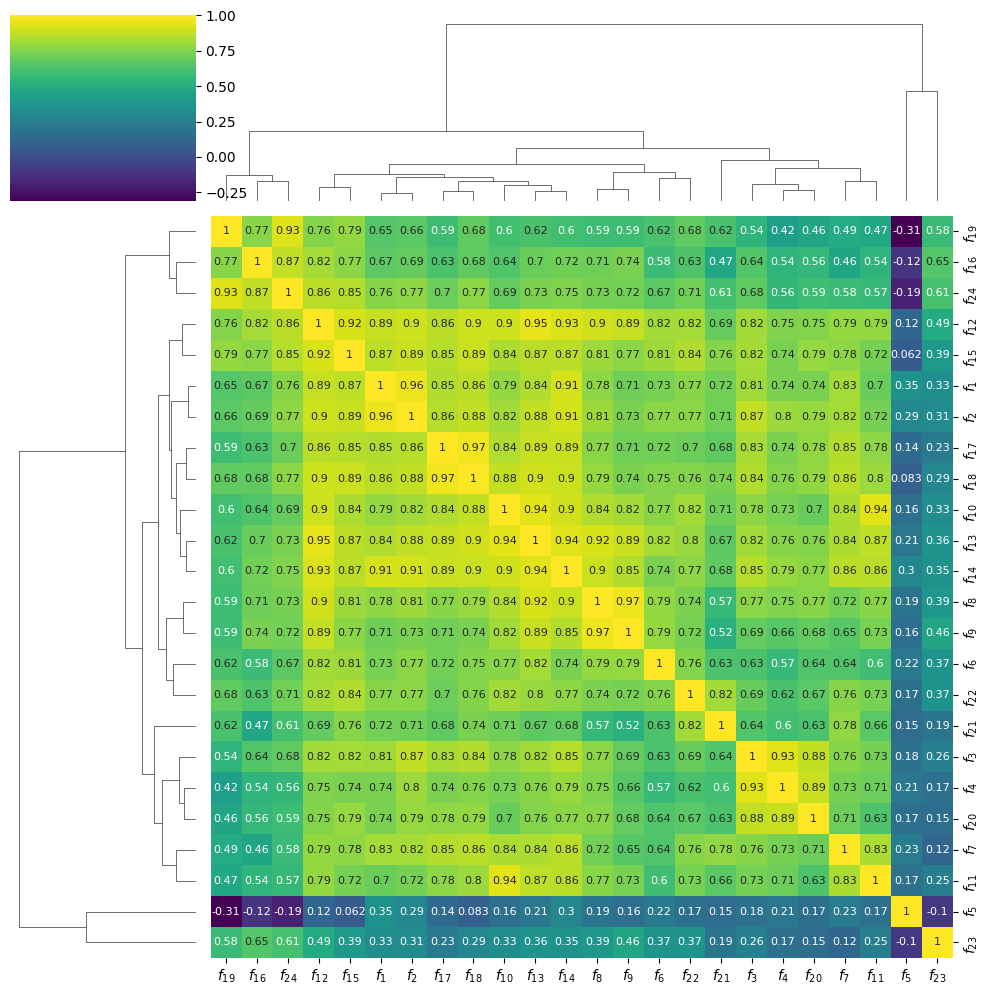

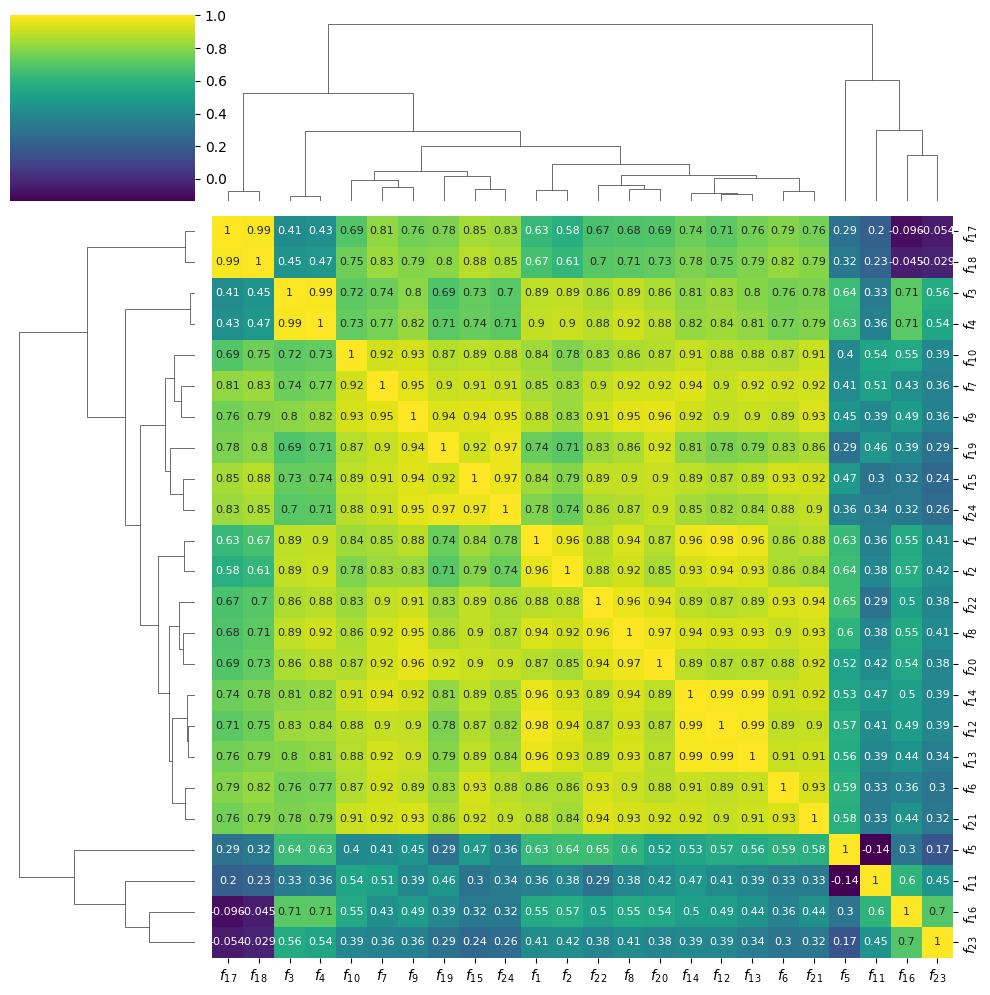

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


df = de_explainer.df
for dim in de_explainer.dims:
    fid_auc_matrix = []
    for fid in de_explainer.fids:
        df_dim_fid = df[(df['dim']==dim) & (df['fid'] == fid)]
        
        fid_auc_matrix.append(df_dim_fid.groupby(features)['auc'].mean())

    fid_auc_matrix = np.array(fid_auc_matrix).T

    df_matrix = pd.DataFrame(fid_auc_matrix, columns=[f"$f_{{{i}}}$" for i in np.arange(1,25)])
    corr = df_matrix.corr()
    g = sns.clustermap(corr, 
                    method = 'complete', 
                    cmap   = 'viridis', 
                    annot  = True, 
                    annot_kws = {'size': 8})
    plt.tight_layout()
    plt.savefig(f"de-clustermap-{dim}d.pdf")